# Image processing HST/ACS and JWST/NIRCam

This process includes PSF matching and spatial resampling and reprojection that match the spatial resolution and sampling of the multiband images

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

## Setup inputs

In [2]:
# list of filters
filters = ['hst_acs_f435w', 'hst_acs_f475w', 'hst_acs_f606w', 'hst_acs_f814w', 
           'jwst_nircam_f090w',  'jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f200w', 
           'jwst_nircam_f277w', 'jwst_nircam_f356w', 'jwst_nircam_f410m', 'jwst_nircam_f444w']
nbands = len(filters)

# image directory
dir_images = 'images/'

# input science images
sci_img = {}
sci_img['hst_acs_f435w'] = 'sunrise-v2-f435w_drc_sci.fits.gz'
sci_img['hst_acs_f475w'] = 'sunrise-v2-f475w_drc_sci.fits.gz' 
sci_img['hst_acs_f606w'] = 'sunrise-v2-f606w_drc_sci.fits.gz'
sci_img['hst_acs_f814w'] = 'sunrise-v2-f814w_drc_sci.fits.gz'
sci_img['jwst_nircam_f090w'] = 'sunrise-v2-f090w-clear_drc_sci.fits.gz' 
sci_img['jwst_nircam_f115w'] = 'sunrise-v2-f115w-clear_drc_sci.fits.gz' 
sci_img['jwst_nircam_f150w'] = 'sunrise-v2-f150w-clear_drc_sci.fits.gz'
sci_img['jwst_nircam_f200w'] = 'sunrise-v2-f200w-clear_drc_sci.fits.gz'
sci_img['jwst_nircam_f277w'] = 'sunrise-v2-f277w-clear_drc_sci.fits.gz'
sci_img['jwst_nircam_f356w'] = 'sunrise-v2-f356w-clear_drc_sci.fits.gz'
sci_img['jwst_nircam_f410m'] = 'sunrise-v2-f410m-clear_drc_sci.fits.gz' 
sci_img['jwst_nircam_f444w'] = 'sunrise-v2-f444w-clear_drc_sci.fits.gz'

# input weight images
wht_img = {}
wht_img['hst_acs_f435w'] = 'sunrise-v2-f435w_drc_wht.fits.gz'
wht_img['hst_acs_f475w'] = 'sunrise-v2-f475w_drc_wht.fits.gz' 
wht_img['hst_acs_f606w'] = 'sunrise-v2-f606w_drc_wht.fits.gz'
wht_img['hst_acs_f814w'] = 'sunrise-v2-f814w_drc_wht.fits.gz' 
wht_img['jwst_nircam_f090w'] = 'sunrise-v2-f090w-clear_drc_wht.fits.gz'
wht_img['jwst_nircam_f115w'] = 'sunrise-v2-f115w-clear_drc_wht.fits.gz' 
wht_img['jwst_nircam_f150w'] = 'sunrise-v2-f150w-clear_drc_wht.fits.gz'
wht_img['jwst_nircam_f200w'] = 'sunrise-v2-f200w-clear_drc_wht.fits.gz'
wht_img['jwst_nircam_f277w'] = 'sunrise-v2-f277w-clear_drc_wht.fits.gz'
wht_img['jwst_nircam_f356w'] = 'sunrise-v2-f356w-clear_drc_wht.fits.gz'
wht_img['jwst_nircam_f410m'] = 'sunrise-v2-f410m-clear_drc_wht.fits.gz' 
wht_img['jwst_nircam_f444w'] = 'sunrise-v2-f444w-clear_drc_wht.fits.gz'

# input variance images
var_img = {}
for bb in range(nbands):
    var_img[filters[bb]] = 'var_'+wht_img[filters[bb]]
    
# Convolution kernels for PSF matching
dir_kernel = 'kernels/'
kernels = {}
kernels['hst_acs_f435w'] = dir_kernel+'kernel_HST_F435W_to_JWST_F444W.fits'
kernels['hst_acs_f475w'] = dir_kernel+'kernel_HST_F475W_to_JWST_F444W.fits'
kernels['hst_acs_f606w'] = dir_kernel+'kernel_HST_F606W_to_JWST_F444W.fits'
kernels['hst_acs_f814w'] = dir_kernel+'kernel_HST_F814W_to_JWST_F444W.fits'
kernels['jwst_nircam_f090w'] = dir_kernel+'kernel_JWST_F090W_to_JWST_F444W.fits'
kernels['jwst_nircam_f115w'] = dir_kernel+'kernel_JWST_F115W_to_JWST_F444W.fits'
kernels['jwst_nircam_f150w'] = dir_kernel+'kernel_JWST_F150W_to_JWST_F444W.fits'
kernels['jwst_nircam_f200w'] = dir_kernel+'kernel_JWST_F200W_to_JWST_F444W.fits'
kernels['jwst_nircam_f277w'] = dir_kernel+'kernel_JWST_F277W_to_JWST_F444W.fits'
kernels['jwst_nircam_f356w'] = dir_kernel+'kernel_JWST_F356W_to_JWST_F444W.fits'
kernels['jwst_nircam_f410m'] = dir_kernel+'kernel_JWST_F410M_to_JWST_F444W.fits'
kernels['jwst_nircam_f444w'] = None

# Pixel size, unit, and scale
# Pixel size can be obtained using calc_pixsize function
from piXedfit.piXedfit_images import calc_pixsize

img_unit = {}
img_scale = {}
img_pixsizes = {}
for bb in range(0,nbands):
    img_unit[filters[bb]] = 'erg/s/cm2/A'
    
    hdu = fits.open(dir_images+sci_img[filters[bb]])
    img_scale[filters[bb]] = float(hdu[0].header['PHOTFLAM'])
    hdu.close()
    
    img_pixsizes[filters[bb]] = calc_pixsize(dir_images+sci_img[filters[bb]])

# The coordinate and redshift of the target galaxy. 
# In general, redshift information is optional here. 
# We use spectroscopic redshift here
gal_ra = 24.347693 
gal_dec = -8.477492 
gal_z = 1.949300

# Size of the final stamp images
stamp_size = [121,121]

## Run image processing

In [3]:
# Call images_processing class
from piXedfit.piXedfit_images import images_processing

img_process = images_processing(filters, sci_img, var_img, gal_ra, gal_dec, dir_images=dir_images, img_unit=img_unit, 
                                img_scale=img_scale, img_pixsizes=img_pixsizes, kernels=kernels, gal_z=gal_z, 
                                stamp_size=stamp_size, remove_files=False)

produce crop_sunrise-v2-f435w_drc_sci.fits.gz
produce crop_var_sunrise-v2-f435w_drc_wht.fits.gz
produce crop_sunrise-v2-f475w_drc_sci.fits.gz
produce crop_var_sunrise-v2-f475w_drc_wht.fits.gz
produce crop_sunrise-v2-f606w_drc_sci.fits.gz
produce crop_var_sunrise-v2-f606w_drc_wht.fits.gz
produce crop_sunrise-v2-f814w_drc_sci.fits.gz
produce crop_var_sunrise-v2-f814w_drc_wht.fits.gz
produce crop_sunrise-v2-f090w-clear_drc_sci.fits.gz
produce crop_var_sunrise-v2-f090w-clear_drc_wht.fits.gz
produce crop_sunrise-v2-f115w-clear_drc_sci.fits.gz
produce crop_var_sunrise-v2-f115w-clear_drc_wht.fits.gz
produce crop_sunrise-v2-f150w-clear_drc_sci.fits.gz
produce crop_var_sunrise-v2-f150w-clear_drc_wht.fits.gz
produce crop_sunrise-v2-f200w-clear_drc_sci.fits.gz
produce crop_var_sunrise-v2-f200w-clear_drc_wht.fits.gz
produce crop_sunrise-v2-f277w-clear_drc_sci.fits.gz
produce crop_var_sunrise-v2-f277w-clear_drc_wht.fits.gz
produce crop_sunrise-v2-f356w-clear_drc_sci.fits.gz
produce crop_var_sunrise

## Plot output stamp images

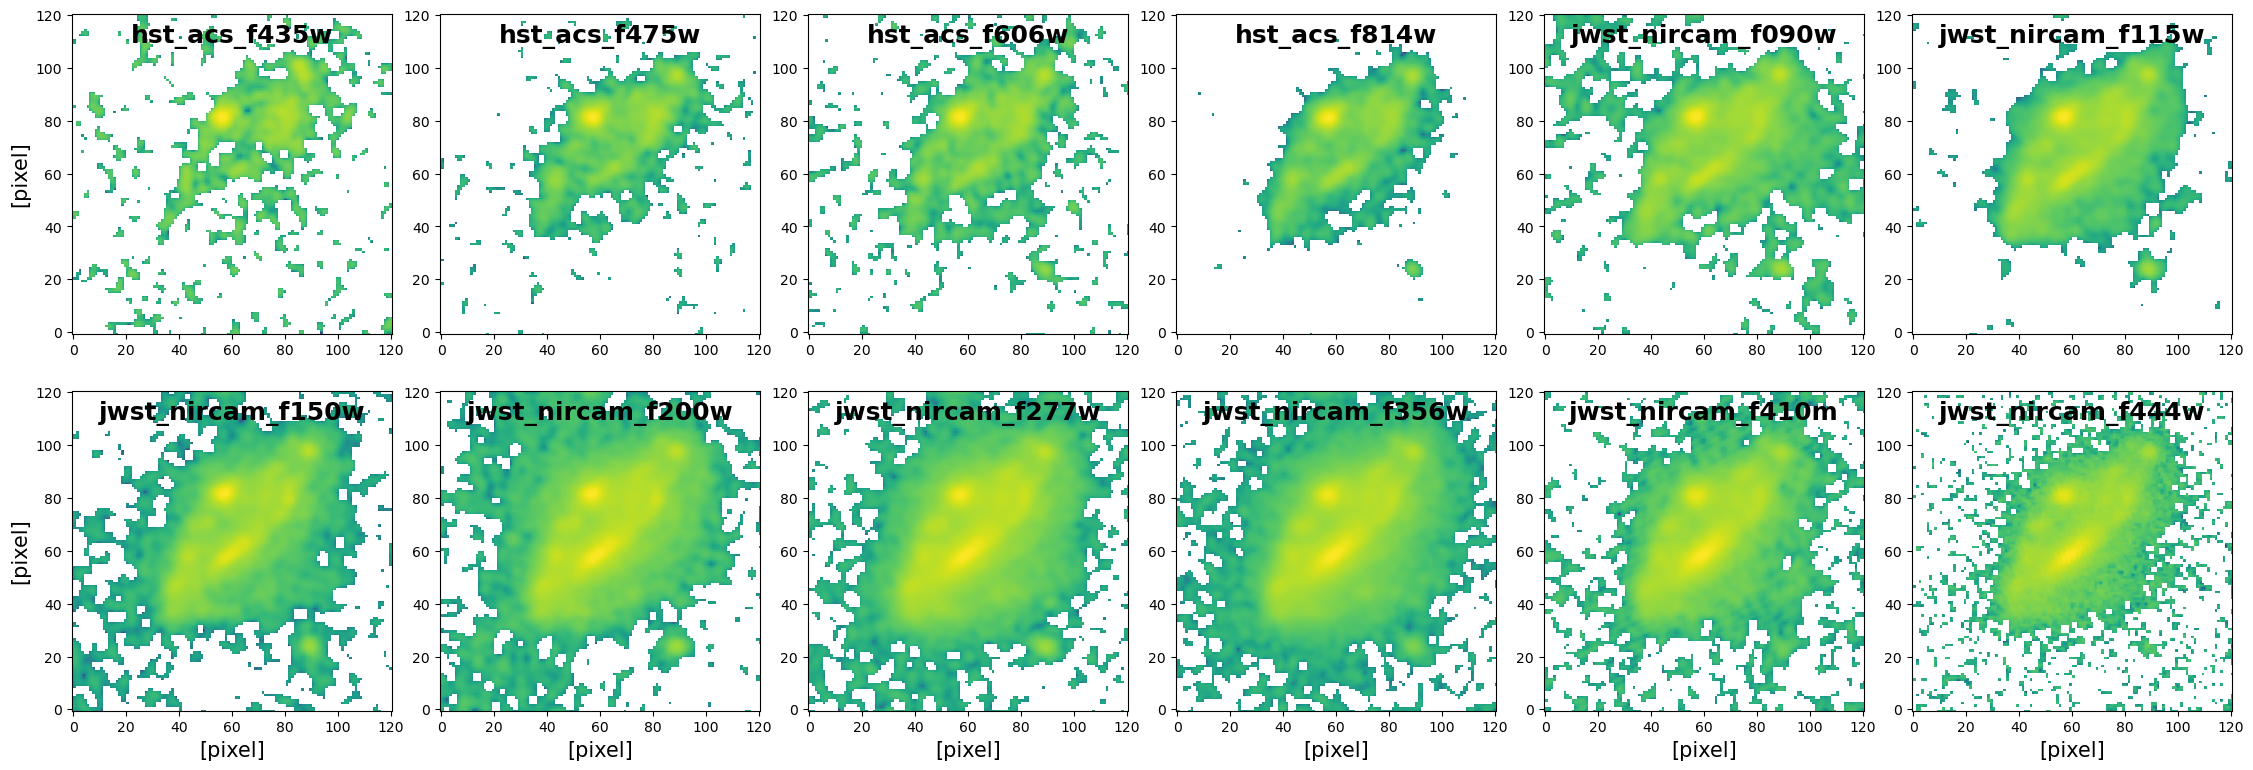

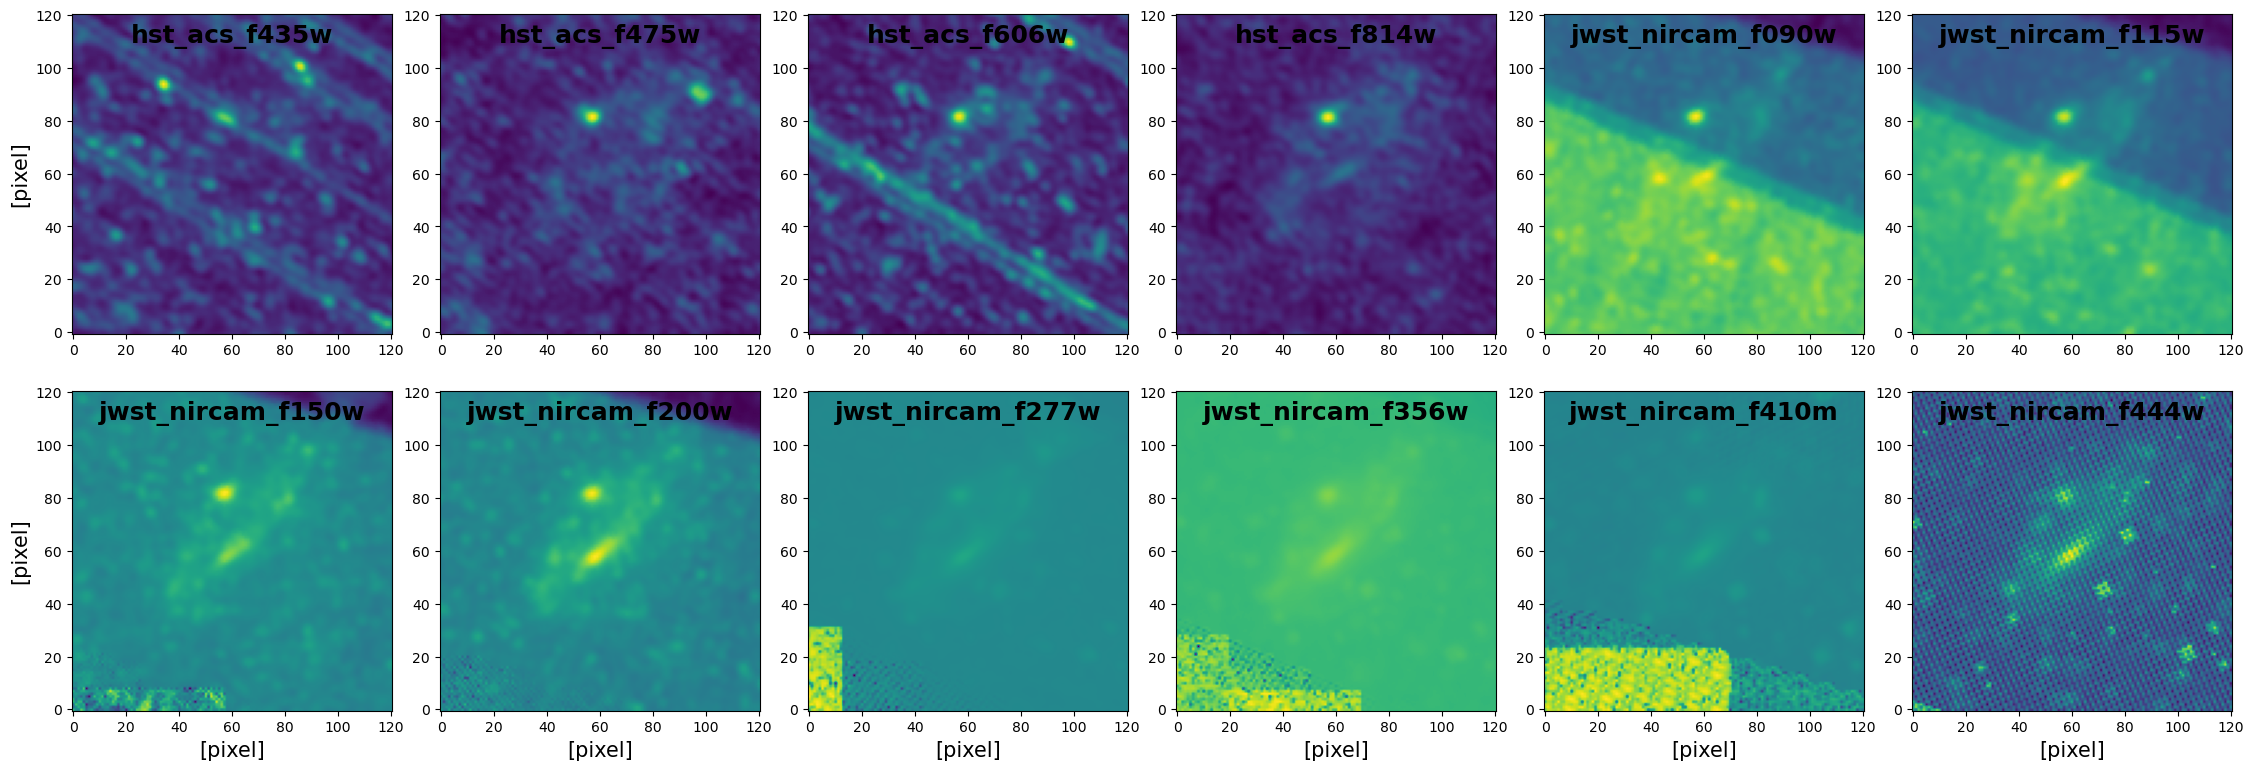

In [4]:
%matplotlib inline
img_process.plot_image_stamps(ncols=6)

## Define galaxy's region of interest using segmentation maps

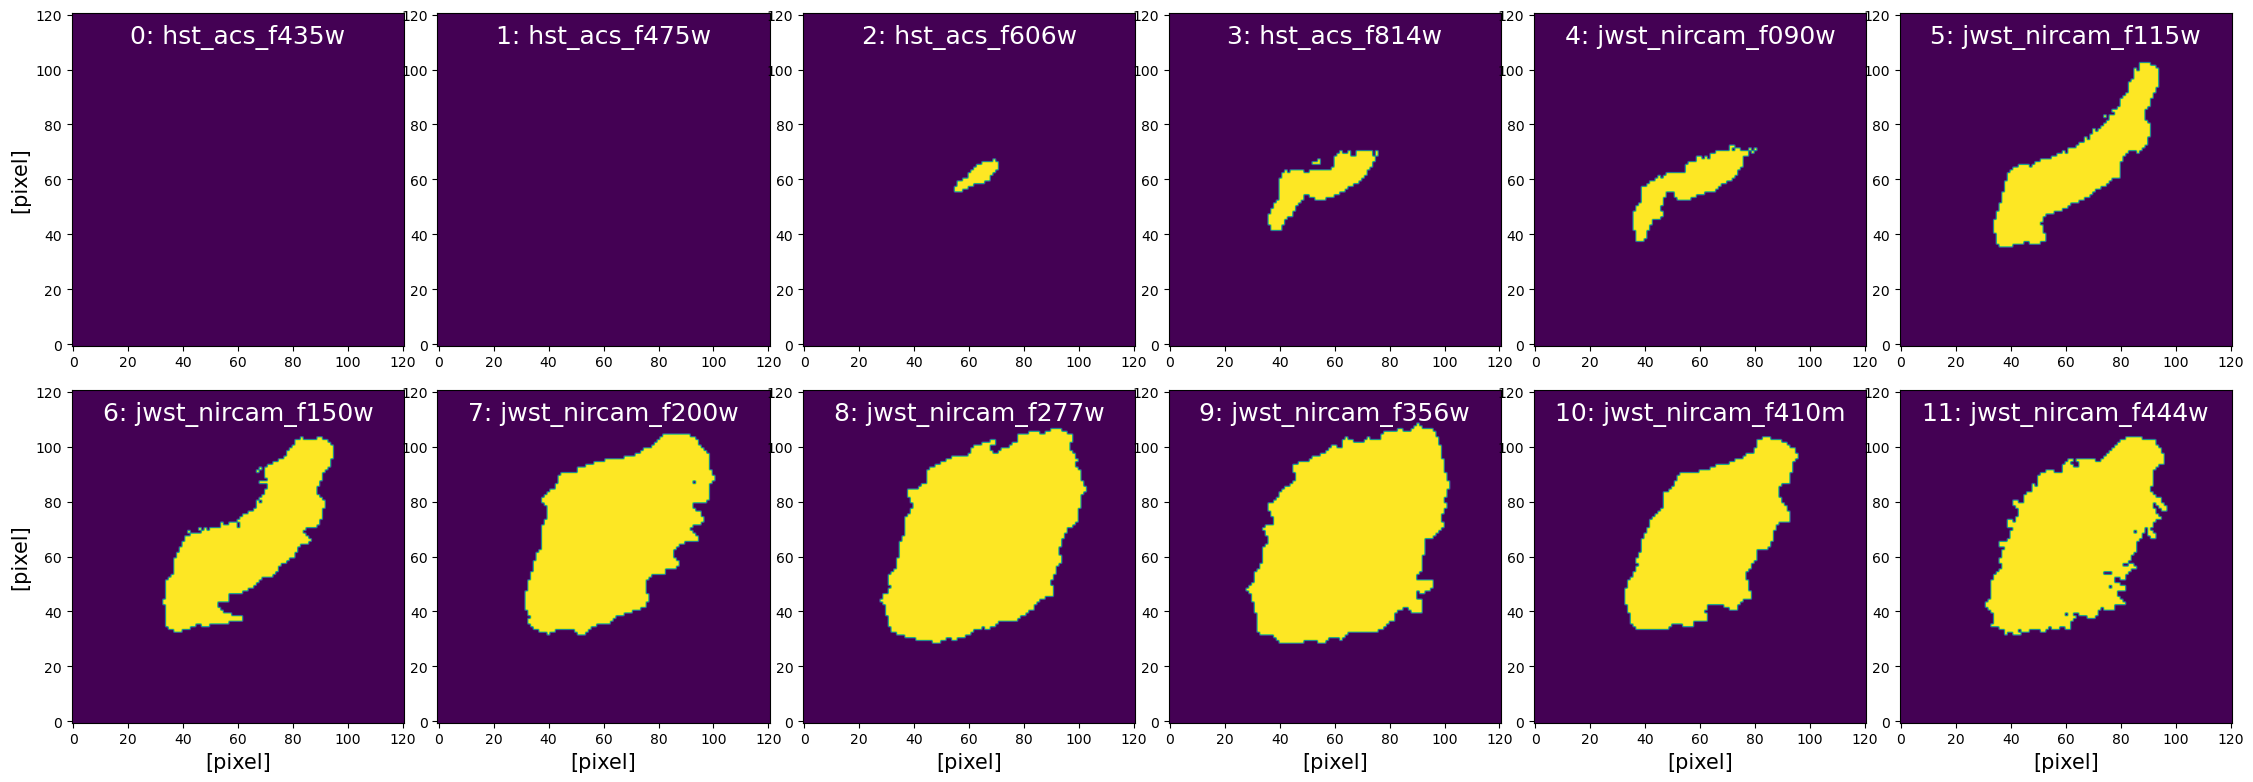

In [6]:
img_process.segmentation_sep(thresh=1.5, minarea=0, deblend_nthresh=32, deblend_cont=0.05)
img_process.plot_segm_maps(ncols=6)

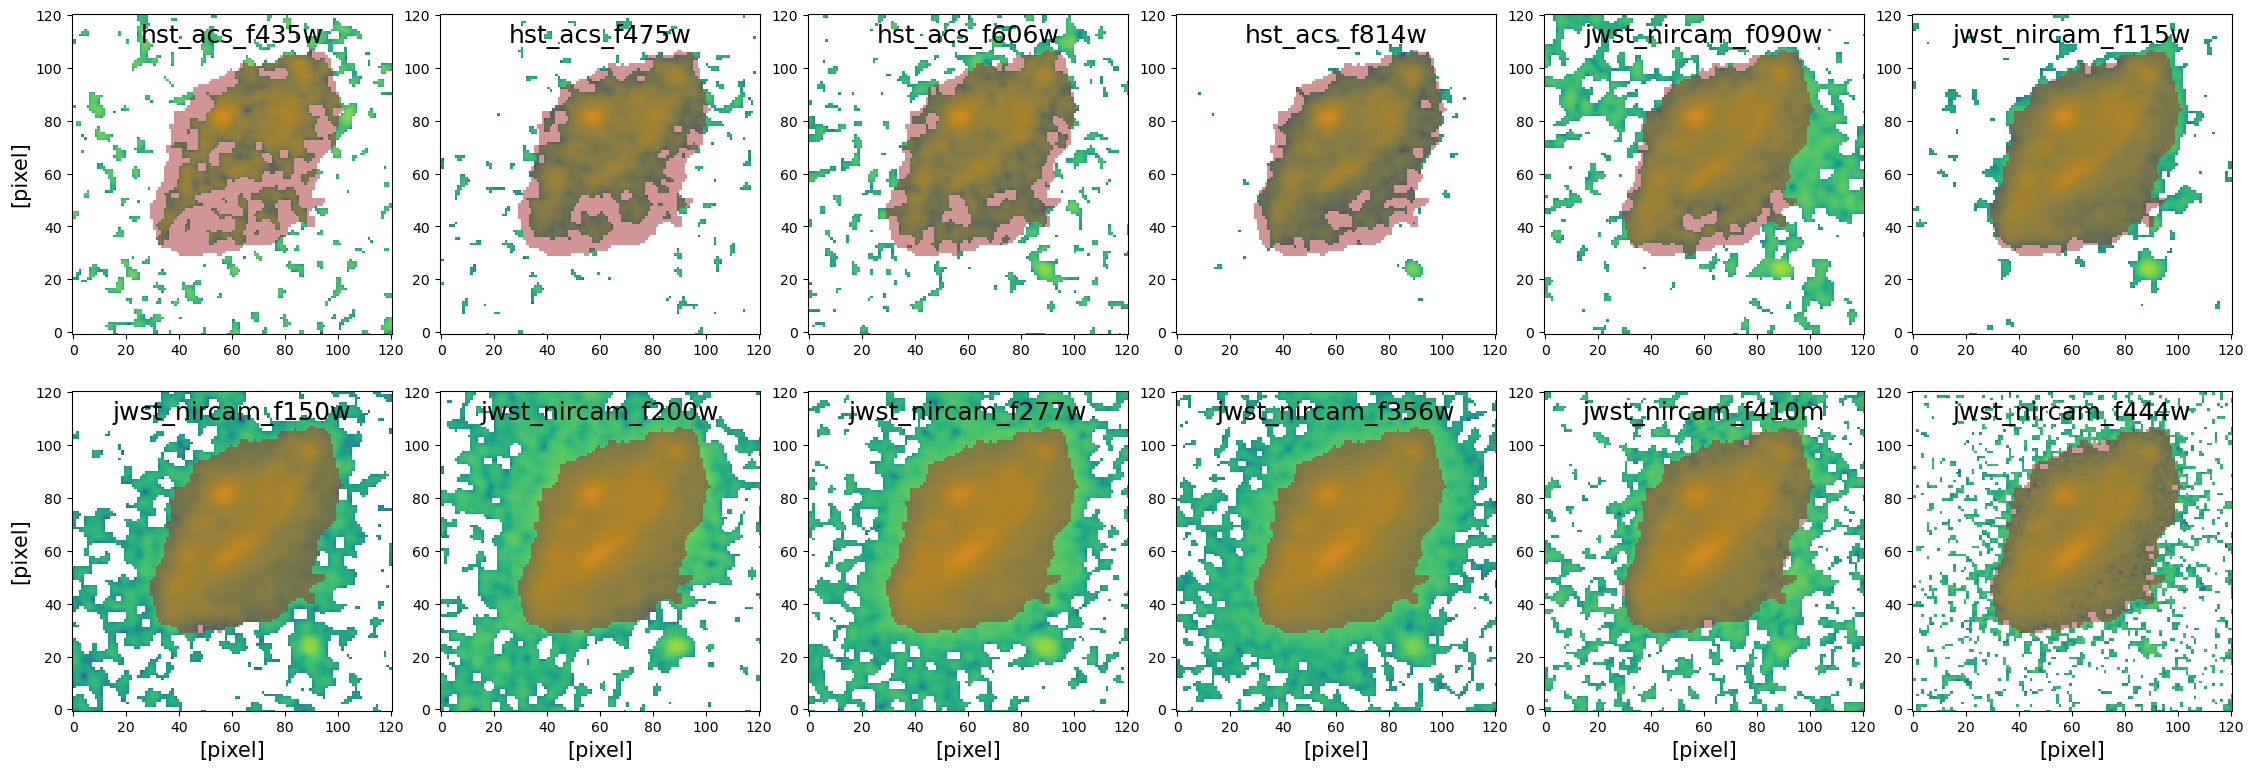

In [7]:
# Define galaxy's region by merging segmentation maps from all bands
segm_maps_ids = None
gal_region = img_process.galaxy_region(segm_maps_ids)

# plot the defined galaxy's region
img_process.plot_gal_region(gal_region, ncols=6)

## Calculate the SEDs of pixels and produce photometric data cube

In [8]:
# Get the estimate of foreground Galactic dust extinction
from piXedfit.piXedfit_images import EBV_foreground_dust

Gal_EBV = EBV_foreground_dust(gal_ra, gal_dec)
print ('Gal_EBV = %lf' % Gal_EBV)

Gal_EBV = 0.028179


In [9]:
flux_maps_fits = "fluxmap_whl0137_z2.fits"
img_process.flux_map(gal_region, Gal_EBV=Gal_EBV, name_out_fits=flux_maps_fits)

'fluxmap_whl0137_z2.fits'

## Plot maps of fluxes and flux uncertainties

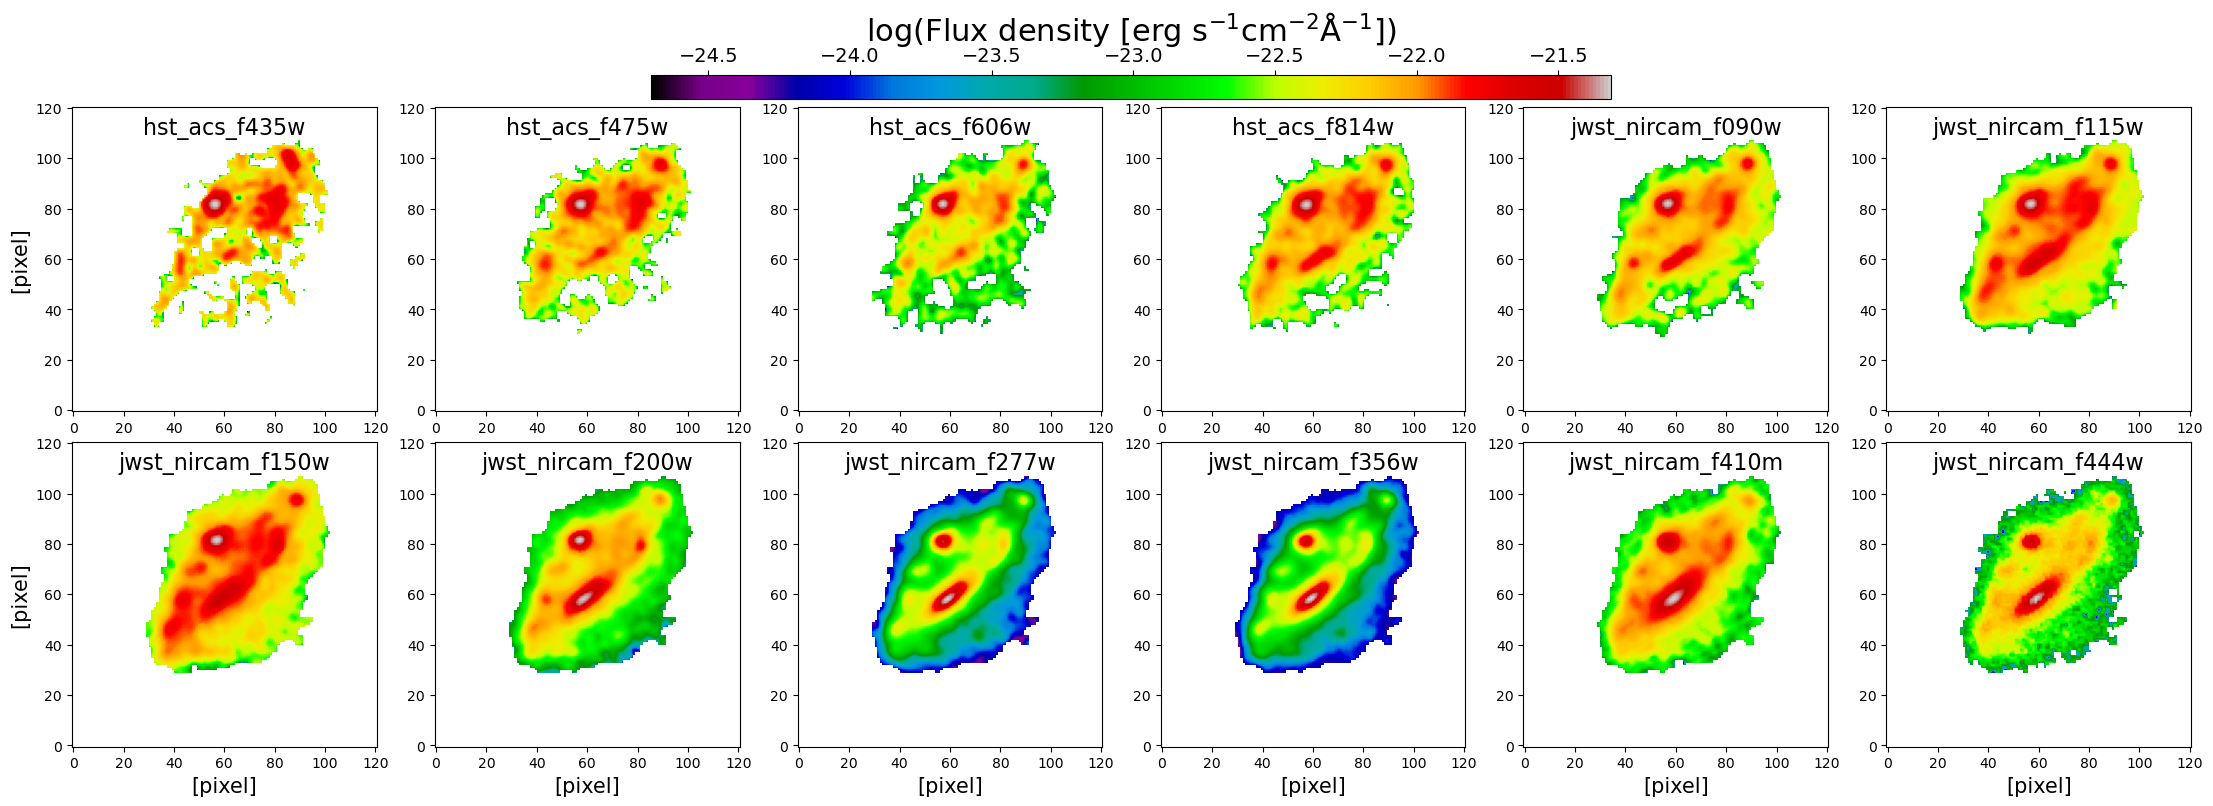

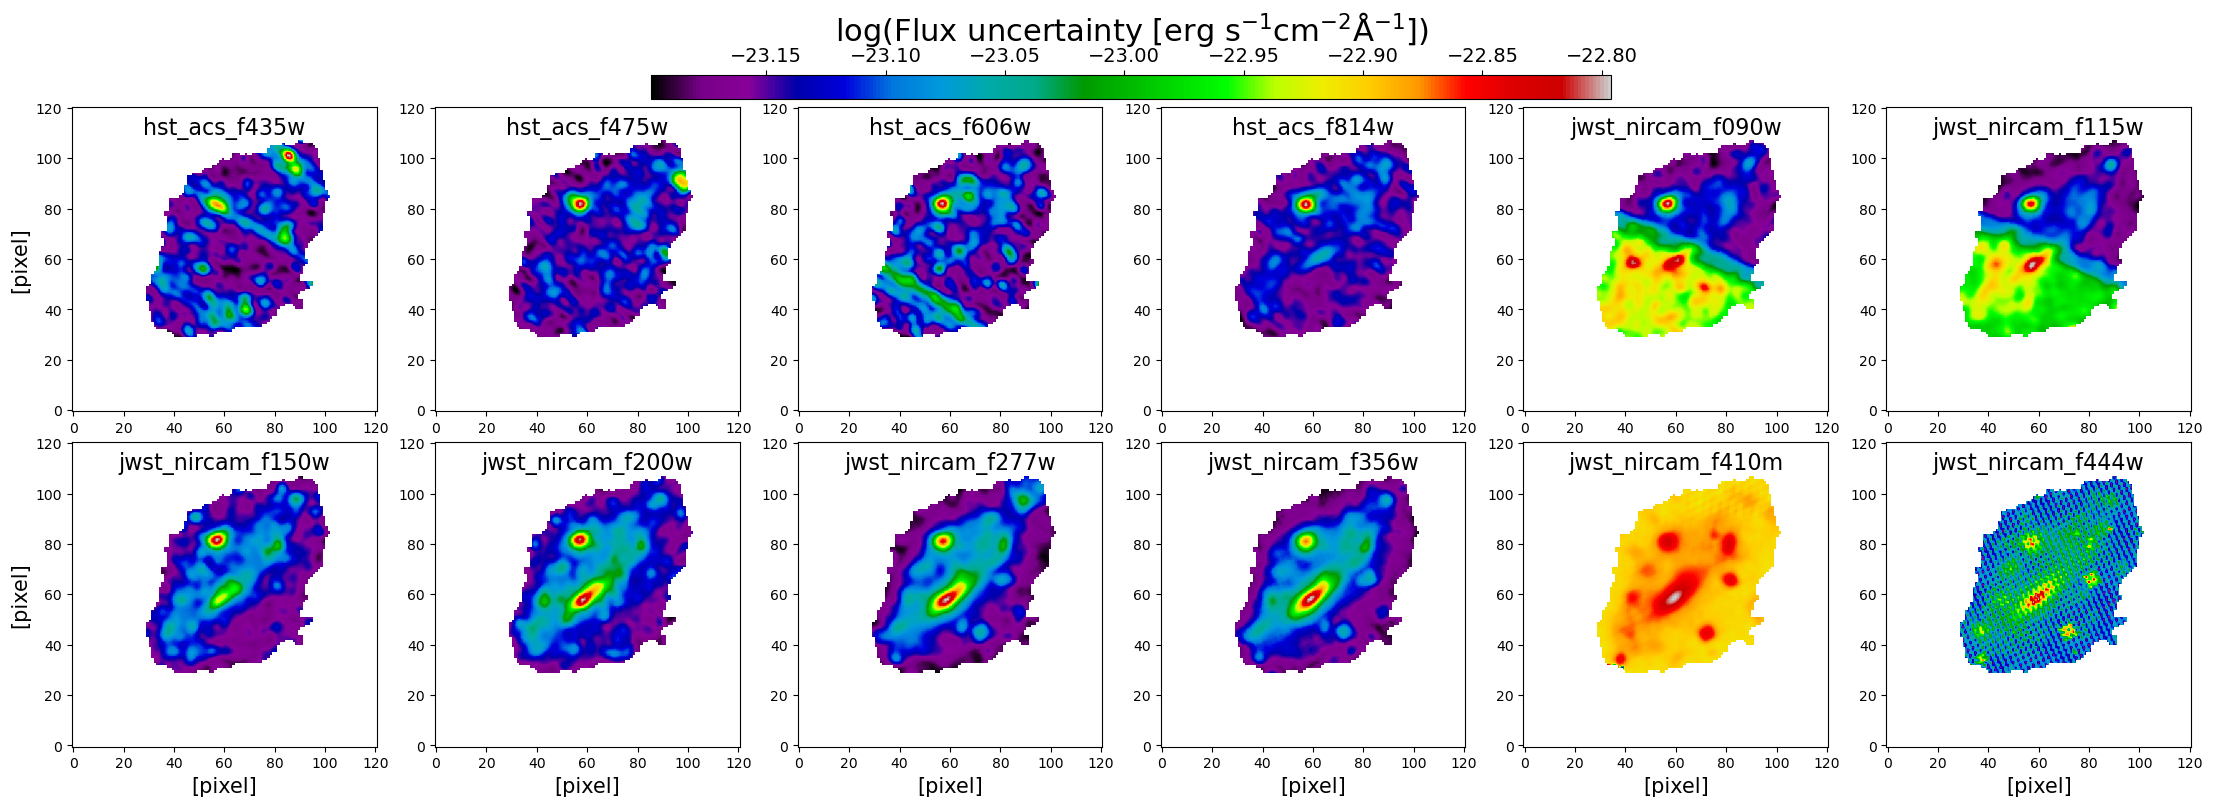

In [10]:
from piXedfit.piXedfit_images import plot_maps_fluxes

plot_maps_fluxes(flux_maps_fits, ncols=6)

## Plot SEDs of some pixels

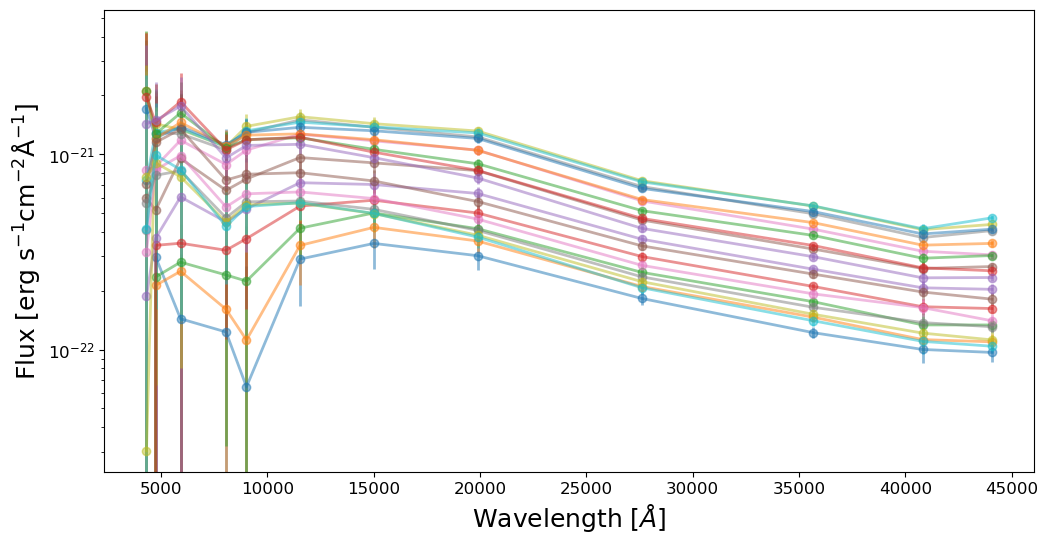

In [16]:
# plot SEDs of some pixels around the center
from piXedfit.piXedfit_images import get_pixels_SED_fluxmap

y_cent, x_cent = (gal_region.shape[0]-1)/2, (gal_region.shape[1]-1)/2
pix_x = np.arange(x_cent-10,x_cent+10)
pix_y = np.arange(y_cent-10,y_cent+10)
pix_x, pix_y, pix_SED_flux, pix_SED_flux_err, photo_wave = get_pixels_SED_fluxmap(flux_maps_fits, pix_x=pix_x, pix_y=pix_y)

fig1 = plt.figure(figsize=(12,6))
f1 = plt.subplot()
f1.set_yscale('log')
plt.xlabel(r"Wavelength [$\AA$]", fontsize=18)
plt.ylabel(r"Flux [erg $\rm{s}^{-1}\rm{cm}^{-2}\AA^{-1}$]", fontsize=18)
plt.setp(f1.get_xticklabels(), fontsize=12)
plt.setp(f1.get_yticklabels(), fontsize=12)

for ii in range(len(pix_x)):
    plt.errorbar(photo_wave, pix_SED_flux[ii], yerr=pix_SED_flux_err[ii], fmt='-o', lw=2, alpha=0.5)

## Plot radial profiles of S/N ratios

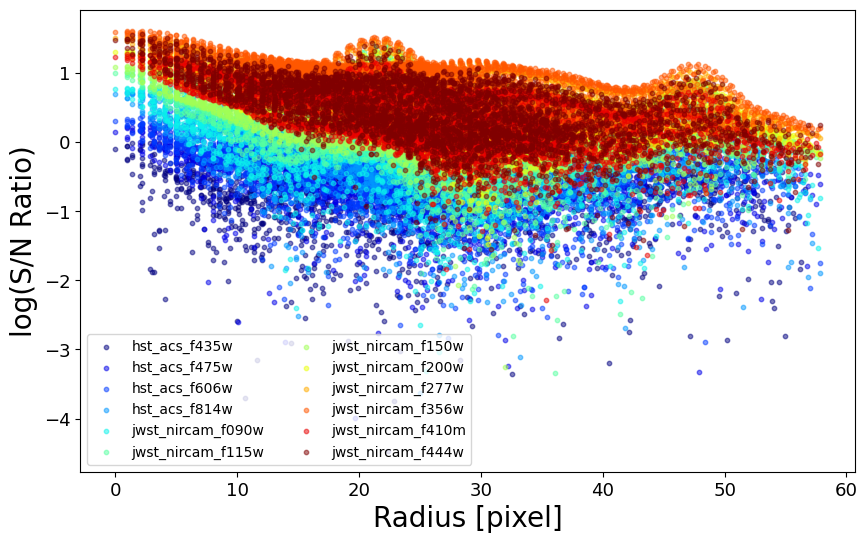

In [17]:
from piXedfit.piXedfit_images import plot_SNR_radial_profile

plot_SNR_radial_profile(flux_maps_fits)